# Neighbourhood Analysis

## Adding latitude and longitude to Ames Properties

In [1]:
#Importing base libraries
import numpy as np
import pandas as pd

house_features = pd.read_csv('data/ames3.csv')
pd.set_option('display.max_columns', None)

#### Merging *Housing* and *Real Estate* Dataframes

In [2]:
#Importing Real Estate dataframe
re_df = pd.read_csv('data/Ames_Real_Estate_Data.csv', low_memory = False)
re_df.head(2)

#Merging the two Ames dataframes to add property address to housing data
df = house_features.merge(re_df[['MapRefNo', 'Prop_Addr']], how = 'left',\
                          left_on = 'pid', right_on = 'MapRefNo')

#Checking to see if Prop_Addr was added to merged df
df.Prop_Addr[0:2]

0    436 HAYWARD AVE
1       3416 WEST ST
Name: Prop_Addr, dtype: object

#### Adding Lat / Long with geopy

In [3]:
#Importing required packages
import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [4]:
locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds = 0.05)
locations = [geocode(addr+', Ames, USA') if type(addr) == str else None for addr in df['Prop_Addr']]

latlong = [[i.latitude, i.longitude] if i != None else None for i in locations]

df['latitude'] = [i.latitude if i != None else None for i in locations]
df['longitude'] = [i.longitude if i != None else None for i in locations]

#Checking for NaN values in latitude and longitude, as well as property address
print(f'Total rows missing lat + long: {df.latitude.isna().sum()}\n')
print(f'Total rows missing property address: {df.Prop_Addr.isna().sum()}\n')

Total rows missing lat + long: 85

Total rows missing property address: 19



In [5]:
#Dropping rows with no address
df = df.drop(df.loc[df['Prop_Addr'].isna()].index, axis = 0)

#Checking if rows with no address had been dropped
print(f'Total rows missing lat + long: {df.latitude.isna().sum()}\n')
print(f'Total rows missing property address after drop: {df.Prop_Addr.isna().sum()}\n')

#Creating dataframe with missing latitude and longitude following drop of rows with missing property address
latlong_df = df.loc[df['latitude'].isna() & df['longitude'].isna()]

Total rows missing lat + long: 66

Total rows missing property address after drop: 0



In [6]:
#Importing GoogleMaps to use their Geocoder API, which fills latitude + longitudes for property addresses
import googlemaps
KEY = 'insert_api_key'
gmaps = googlemaps.Client(key = KEY)

#Defining a function to pull latitude + longitude coordinates from an address
def get_coords(addr):
    geocode = gmaps.geocode(str(addr)+', Ames, USA')
    if len(geocode) > 0:
        return list(geocode[0]['geometry']['location'].values())
    else:
        return [np.NaN, np.NaN]

    
#Creating a Pandas series following the Prop_Addr to add latitude + longitude to correct address
latlong_sr = latlong_df['Prop_Addr'].apply(lambda x: pd.Series(get_coords(x), 
                                                                    index=['latitude', 'longitude']))

#Adding the correct latitude + longitudes back to the latlong dataframe
latlong_df = pd.concat([latlong_df.drop(columns = ['latitude', 'longitude'])[:],
                           latlong_sr[:]], axis = 1)

#Dropping rows with no address
df = df.drop(df.loc[df['latitude'].isna()].index, axis = 0)

#Adding latlong_df to the main dataframe
df = pd.concat([df[:], latlong_df[:]], axis = 0, ignore_index = True)

#### Plotting Prices in lat / long coordinates

In [7]:
#Importing required packages
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [8]:
df['text'] = df['bldgtype'] + ', ' + df['housestyle'] + '\n' +\
            'Sale Price: ' + df['saleprice'].astype(str) + '\n' +\
            df['neighborhood']

fig = go.Figure(data=go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'inferno',
            color = np.log10(df['saleprice'].values),
            colorbar_title = 'Sale Price Range (log)'
        )))

fig.update_geos(
        lataxis_range = [41.980, 42.070],
        lonaxis_range = [-93.70, -93.55],
        landcolor = 'rgb(250, 250, 250)',
        subunitcolor = 'rgb(217, 217, 217)',
        countrycolor = 'rgb(217, 217, 217)',
        countrywidth = 0.5,
        subunitwidth = 0.5
    )

fig.update_layout(
        title = 'Ames Housing Prices',
        title_x = 0.5
    )

fig.show()

Although the *plotly* graph shows a general understanding of where houses in Ames are located in terms of sales price, it would be better to see where major attractions or workplaces (such as the University and DoT) are located. Basemap is used below to layer satellite imaging to these points.

## Mapping with Basemap

**Party Parrots!**
Should you decide to run the code below, there are some packages that need to be installed.<br><br>
Please run the following code in your terminal window:<br><br>
conda activate test<br>
conda list proj *#if no proj is listed, follow steps immediately below*<br>
conda install proj -c conda-forge<br>
conda install pyproj<br>
conda list proj *#here both proj and pyproj should show up with conda-forge as its' channel*<br>
conda install basemap -c conda-forge<br>
conda list basemap *#here basemap should show up with conda-forge as its' channel*<br>
python -c "from mpl_toolkits.basemap import Basemap"<br>
env | grep -i proj<br><br>
**The following message should be displayed:**<br>
PROJ_LIB=/Applications/anaconda3/envs/test/share/proj<br>
PROJ_NETWORK=ON

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



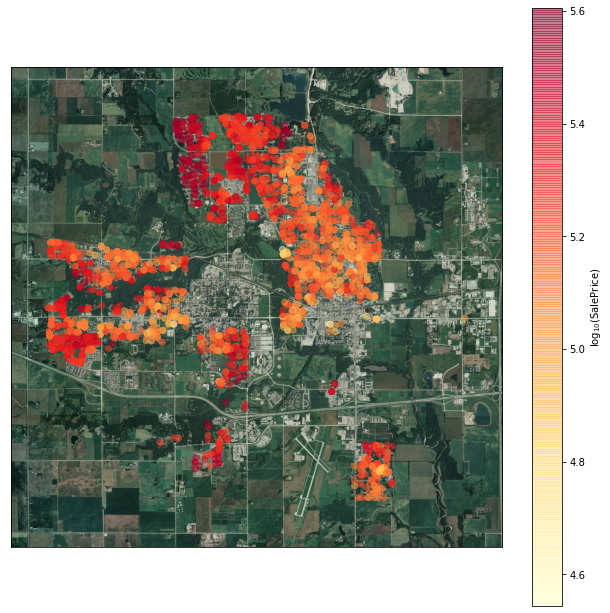

In [9]:
#Different from user to user - each user running the code below should specify where the anaconda folder is in
#computer - the remainder of the path can be kept the same
import os
#os.environ['PROJ_LIB'] = 'USER_PATH/anaconda3/share/proj'
os.environ['PROJ_LIB'] = '/Applications/anaconda3/share/proj'

def plot_coordinates(lat, lon, color_parameter, scale = None):
    """
    This function plots latitude & longitude coordinates specifically for Ames, Iowa for a specified
    parameter.
    
    Arguments:
    
    lat             : (dataframe column values) latitude values 
    lon             : (dataframe column values) longitude values
    color_parameter : (dataframe column values) specified parameter for coloring scatter points
    scale           : (str, default : None) option to use any other scale for color_parameter, such as log

    Returns:
    
    plt             : (Basemap plot) scatterplot of all points colored by specified parameter

    """     
    
    from mpl_toolkits.basemap import Basemap

    fig = plt.figure(figsize=(11, 11))
    
    #Determine range to print based on min, max lat and lon of the data
    margin = 0.01 #Buffer to add to the range for visualization
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    
    #Create map
    m = Basemap(llcrnrlon = lon_min,
                llcrnrlat = lat_min,
                urcrnrlon = lon_max,
                urcrnrlat = lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection = 'merc',
                resolution = 'h',
                area_thresh = 10000.,
                epsg = 2794
                )
    
    #Adding a satellite image through specified epsg in m basemap definition
    m.arcgisimage(service = 'ESRI_Imagery_World_2D', xpixels = 1500)
    
    
    #Plotting the scatter and legend
    if scale == 'log':
        m.scatter(lon, lat, latlon=True,
        c = np.log10(color_parameter),
        cmap = 'YlOrRd', alpha=0.5)
        plt.colorbar(label=r'$\log_{10}({\rm Sale Price})$')
    else:
        m.scatter(lon, lat, latlon=True,
        c = color_parameter,
        cmap = 'Paired', alpha = 1)
        cb = m.colorbar(label='Scale')
    
    
    #Showing the final plot
    plt.show()

    
plot_coordinates(df['latitude'].values, df['longitude'].values, df['saleprice'].values, scale = 'log')

## Does Location Play a Role in Sale Price?

Before going into feature selection, Party Parrots wanted to answer the question whether location plays a role in Sale Price (does the saying "Location, location, location!" matter?). As such a KNN Regression model was ran below.

### Insights through KNN Regression

#### Rule-of-Thumb K Value

In [10]:
#Calculating k via rule-of-thumb to get an estimate of KNRegressor
n = df.shape[0]
k = int((n ** 0.5))
print(f'Rule-of-thumb k-value: {k}')

#Checking for NaN values in X and y dataframes for KNeighborRegr
print(df[['latitude', 'longitude']].isna().sum(), '\n')
print(df[['saleprice']].isna().sum())

Rule-of-thumb k-value: 49
latitude     0
longitude    0
dtype: int64 

saleprice    0
dtype: int64


In [ ]:
#Creating latitude for Euclidean distances
# import math as ma

# df['longitude_euc'] = df['longitude']*ma.cos(42)
# df['latitude_tr'] = df['longitude_euc']*df['latitude']

#### KNN Regressor

In [11]:
#Setting the X and y variables
X = df[['longitude', 'latitude']].values
y = np.log10(df['saleprice'])

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

#Train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

#Using the regressor
knn_regressor = KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
knn_regressor.fit(X_train, y_train)

#Training and test scores
print(f'Training model score: {round(knn_regressor.score(X_train, y_train), 2)}\n')
print(f'Testing model score: {round(knn_regressor.score(X_test, y_test), 2)}\n')

Training model score: 0.56

Testing model score: 0.52



As can be seen above, the rule-of-thumb k-value is bringing down the score of both training and test models. As can be seen, there is some overfitting on the training mode. As such, it would be beneficial to bring the score up as well as remove over-fittedness by using Grid Search. The model will then be recalculated and neighbourhood groupings will be allocated.

#### Implementing GridSearchCV to tune K value

In [12]:
from sklearn.model_selection import GridSearchCV

#Setting the possible parameters range up until the rule-of-thumb k value
grid_param = [{'n_neighbors': range(3, 51)}]

k_search = GridSearchCV(estimator = knn_regressor, param_grid = grid_param, 
                           scoring = 'r2', cv = 10, return_train_score = True)
# neg_mean_squared_error
k_search = k_search.fit(X_train, y_train)

#Checking the best generated results
print(f'Best score for fitted model: {round(k_search.best_score_, 2)}\n')
print(f'Best estimator for KNN Regressor: {k_search.best_params_}\n')

#Refitting the best k to test data set and checking the score
print(f'Test score after finding best k: {round(k_search.score(X_test, y_test), 2)}\n')

Best score for fitted model: 0.66

Best estimator for KNN Regressor: {'n_neighbors': 3}

Test score after finding best k: 0.62



In [13]:
#Generating report with ascending mean test scores
grid_report = pd.DataFrame(k_search.cv_results_)
grid_report.sort_values('mean_test_score', ascending=False).head().T

0                   1  \
mean_fit_time               0.00142758         0.000952554   
std_fit_time               0.000541376         0.000262788   
mean_score_time             0.00178053          0.00120804   
std_score_time             0.000998107         0.000318206   
param_n_neighbors                    3                   4   
params              {'n_neighbors': 3}  {'n_neighbors': 4}   
split0_test_score             0.608348            0.618731   
split1_test_score             0.693726            0.696692   
split2_test_score             0.703554            0.702794   
split3_test_score             0.685052            0.667559   
split4_test_score             0.603785            0.603365   
split5_test_score             0.630632            0.638601   
split6_test_score             0.767567             0.78417   
split7_test_score             0.611467            0.598634   
split8_test_score             0.713656            0.695292   
split9_test_score             0.611568            0.608934   
mean_test_score               0.662936            0.661477   
std_test_score               0.0542377           0.0562306   
rank_test_score                      1                   2   
split0_train_score            0.844154            0.813834   
split1_train_score             0.83864            0.807108   
split2_train_score            0.835847            0.804089   
split3_train_score            0.839261            0.804106   
split4_train_score            0.845553            0.811219   
split5_train_score            0.833771            0.803649   
split6_train_score            0.830738            0.798052   
split7_train_score            0.846077            0.815523   
split8_train_score            0.835342            0.802291   
split9_train_score            0.842087            0.812263   
mean_train_score              0.839147            0.807213   
std_train_score             0.00498029          0.00542887   

                                     2                   3                   4  
mean_fit_time              0.000785112         0.000829577         0.000755668  
std_fit_time               2.46912e-05         9.93401e-05         1.13219e-05  
mean_score_time             0.00101278           0.0018368          0.00100946  
std_score_time             8.59451e-05          0.00233342         3.59849e-05  
param_n_neighbors                    5                   6                   7  
params              {'n_neighbors': 5}  {'n_neighbors': 6}  {'n_neighbors': 7}  
split0_test_score             0.609664            0.611223            0.611019  
split1_test_score             0.692714            0.691421            0.693964  
split2_test_score             0.685375             0.67305            0.672828  
split3_test_score             0.654217            0.628288             0.61982  
split4_test_score             0.591879            0.586691            0.576143  
split5_test_score              0.64307            0.633234             0.62432  
split6_test_score              0.77402            0.761365             0.75031  
split7_test_score             0.613014            0.605767             0.60326  
split8_test_score             0.707924            0.716796            0.722048  
split9_test_score             0.629575            0.629558            0.633723  
mean_test_score               0.660145            0.653739            0.650744  
std_test_score               0.0525725           0.0525449           0.0535684  
rank_test_score                      3                   4                   5  
split0_train_score            0.791298            0.774062            0.755395  
split1_train_score            0.782742            0.769395            0.749693  
split2_train_score            0.782783            0.763445            0.750647  
split3_train_score            0.784157            0.761252            0.742721  
split4_train_score            0.788991            0.769322            0.749002  
split5_train_score         

#### Plotting the KNN Regression Results

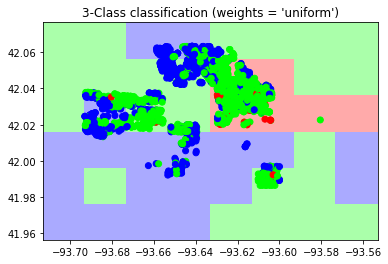

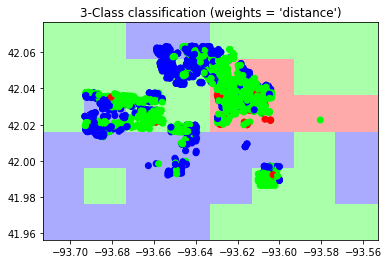

In [14]:
from matplotlib.colors import ListedColormap

h = .02  # step size in the mesh
k = k_search.best_params_['n_neighbors']

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    knn_regressor2 = KNeighborsRegressor(n_neighbors = k, weights = weights)
    knn_regressor2.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 0.02, X[:, 0].max() + 0.03
    y_min, y_max = X[:, 1].min() - 0.03, X[:, 1].max() + 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn_regressor2.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (weights = '%s')" % weights)

plt.show()

#### *Interpretation*

By implementing a KNN Regression model, we can see that about 65% of sale price can be explained by location. As such, we should expect to see neighbourhoods play a role in our future models. Although, that statement should be taken with a grain of salt - some features might already represent neighborhoods one way or another. An example of this could be garages - a neighbourhood that generally has bigger garages might see higher prices. <br><br>
Therefore, the way neighbourhoods will be grouped will determine how neighbourhoods will perform in future models.

### Insights through OLS Regression

With neighborhoods consistently being something sellers instantly think of a selling point, Party Parrots were wondering - would neighbourhoods make it to feature selection with different models? For a sample research, OLS was used.

In [15]:
#Generating dataframe with only neighbourhoods and sale price
df_nbhd_lasso = df.copy()
df_nbhd_lasso.drop(df.columns.difference(['pid', 'saleprice', 'neighborhood', 'house_age']),\
                   1, inplace = True)

#Creating dummified columns for neighborhoods
df_nbhd_lasso = pd.get_dummies(df_nbhd_lasso, columns = ['neighborhood'], prefix_sep = '_')

#Dropping one column to keep as baseline. Mitchel was chosen as it has average housing prices across Ames
df_nbhd_lasso = df_nbhd_lasso.drop(columns = 'neighborhood_Mitchel')

In [16]:
import statsmodels.api as sm 

X = df_nbhd_lasso.drop(columns = ['pid', 'saleprice', 'house_age'])
y = np.log10(df_nbhd_lasso['saleprice'])

X_add_const = sm.add_constant(X)

ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     129.7
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:30:47   Log-Likelihood:                 2170.7
No. Observations:                2497   AIC:                            -4289.
Df Residuals:                    2471   BIC:                            -4138.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.2051 

Here, only one neighborhood is insignificant (p > 0.05). Let's take a look at adding house age to see whether neighborhoods become less significant.

In [17]:
X = df_nbhd_lasso.drop(columns = ['pid', 'saleprice'])
y = np.log10(df_nbhd_lasso['saleprice'])

X_add_const = sm.add_constant(X)

ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     141.5
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:31:17   Log-Likelihood:                 2262.9
No. Observations:                2497   AIC:                            -4472.
Df Residuals:                    2470   BIC:                            -4315.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.2564 

As can be seen above, an additional 5 neighborhoods immediately became insignificant (p > 0.05). This is when only one variable is added! Knowing that the dataframe that will be feed to the models will have over 50 columns, it is quite possible that neighborhoods will not make the final cut, as other variables can explain the differences from neighborhood to neighborhood.<br><br>
As such, grouping neighborhoods might be beneficial in order to keep the significance of neighborhoods in the model. 

## Neighbourhood Grouping

To reduce the number of features required in modelling following dummification, it is possible to re-group some categorical features. Additionally, as per the location insight, neighbourhood grouping can play a role in sale price. As such, Party Parrots have agreed on three possible options of grouping neighbourhoods:<br>
- Geographical  grouping (basic grouping between N / S / E / W areas of Ames)<br>
- Distance to Major Workplaces (calculating distances to major workplaces and grouping by distance bins)<br><br>
The following sections will go over these grouping techniques.

### Grouping 1 - Geographical

In [18]:
#Creatinig a copy of the dataframe to modify based on geographical neighbourhood grouping
df_nbhd_geogrp = df.copy()

#Grouping neighbourhoods based on relative geographical position
grouping_geo = {'ne': ['NoRidge', 'NridgHt', 'Veenker', 'Somerst', 'Greens'],
               'se': ['MeadowV', 'Mitchel'],
               'sw': ['Timber'],
               'east': ['Blmngtn', 'BrkSide', 'Gilbert', 'NAmes', 'NPkVill', 'NWAmes', 'OldTown',
                        'StoneBr', 'BrDale', 'IDOTRR'],
               'west': ['Blueste', 'CollgCr', 'ClearCr', 'Edwards', 'SWISU', 'Crawfor', 'Sawyer', 'SawyerW' ]}

#Adding 'dummified' columns for each neighbourhood group
def add_nbhd_group(df, group_dict):
    """
    This function puts listings from certain neighborhoods into a specified list of groups by creating
    dummified columns for these groups.
    
    Arguments:
    
    df         : (dataframe)  dataframe with all neighborhood
    group_dict : (dictionary) dictionary specifying neighborhood groups

    Returns:
    
    df         : (dataframe) returns original dataframe with dummified neighborhood columns

    """    
    for i in group_dict.keys():
        df['nbhd_'+str(i)] = [1 if x in group_dict.get(i) else 0 for x in df['neighborhood']]

add_nbhd_group(df_nbhd_geogrp, grouping_geo)

#Adding a plotting column
df_nbhd_geogrp['plotting'] = [1 if i in grouping_geo.get('ne')\
                             else 2 if i in grouping_geo.get('se')\
                             else 3 if i in grouping_geo.get('sw')\
                             else 4 if i in grouping_geo.get('east')\
                             else 5 for i in df_nbhd_geogrp['neighborhood']]


#Dropping Neighborhood column
df_nbhd_geogrp = df_nbhd_geogrp.drop(columns = 'neighborhood')

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



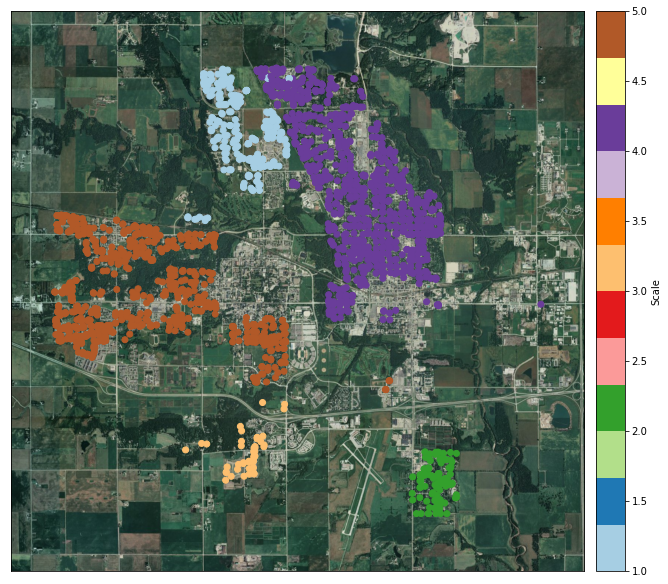

In [19]:
#Plotting neighborhood groups
plot_coordinates(df_nbhd_geogrp['latitude'].values, df_nbhd_geogrp['longitude'].values, 
                 df_nbhd_geogrp['plotting'].values)

In [20]:
df_nbhd_geogrp.to_csv('df_nbhd_geogrp.csv', index = False)

### Grouping 2 - Distance to Major Work Locations

One method of calculating distances between locations suggested in the Machine Learning Project Proposal is to run a simple calculation of a straight distance. With the help of Google's Distance Matrix API, a route to a certain location can be calculated both in the form of distance and average time it took for Google users to travel that distance.<br><br>
Distances to the University of Iowa, the DoT, as well as the College of Veterinary Medicine will be calculated below.

In [21]:
#Creating a dataframe for work / study locations in Ames
work_locations = pd.Series({'uoi':'515 Morrill Rd, Ames, USA',
                 'dot': '800 Lincoln Way, Ames, USA',
                 'vm': '1800 Christensen Dr, Ames, USA'})

#Using previously defined function of get_coords() to obtain coordinates for the addresses of 
#the three major work / study locations in Ames
work_locations = work_locations.apply(lambda x: pd.Series(get_coords(x), 
                                                          index = ['latitude', 'longitude']))

#Printing results
print(work_locations)

#Creatinig a copy of the dataframe to modify neighborhood grouping based on distance to major 
#work / study locations in Ames
df_nbhd_distgrp = df.copy()

In [24]:
import time

#This function will be used later to split lists into sizeable chunks
#This is required due to the nature of Google's Distance Matrix API and the number of requests that can
#be sent every 10 sec
def list_to_chunks(l, n):
    """
    This function splits a given list into chunks with a specified number of values n.
    
    Arguments:
    
    l : list to be split into chunks of n values
    n : number of values to split list to

    Returns:
    
    l : split into chunks version of list l
    
    """    
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

        
def route_calculator(df_origins, df_destinations, dest_index_name, n = 10):
    """
    This function calculates the distance and travel time between two locations using Google Maps's 
    Distance Matrix API. A value for both distance and duration is extracted, and then converted to 
    miles and minutes required for each route.
    
    Arguments:
    
    df_origins      : (dataframe) dataframe containing latitude and longitudes of origin locations
    df_destinations : (dataframe) dataframe containing latitude and longitudes of destination locations
    dest_index_name : (str) name of destination - must be an index in df_destinations
    n               : (int) number of route calculations per request (default = 10)

    Returns:
    
    dist            : (list) list of distances required for each route
    dur             : (list) list of durations required for each route
    
    """
    import googlemaps
    KEY = 'insert_api_key'
    gmaps = googlemaps.Client(key = KEY)
    
    origins = []
    destination = []
    dist = []
    dur = []
    
    #Locating the specified index in the destinations dataframe
    df_destinations = df_destinations.loc[[dest_index_name]]
    
    #Converting columns of lat / long to list of coordinates for both origins and destinations
    for i in range(0, df_origins.shape[0]):
        origins.append(str(df_origins['latitude'][i]) + ',' + str(df_origins['longitude'][i]))
        destination.append(str(df_destinations['latitude'][0]) + ',' + 
                               str(df_destinations['longitude'][0]))
    
    #Splitting the origins and destinations list using list_to_chunks() to meet Google API requirements
    origins_split = list(list_to_chunks(origins, n))
    destination_split = list(list_to_chunks(destination, n))

    #Calculating route for each split list and extracting distance and duration data
    for i in range(0, len(origins_split)):
        route_matrix = gmaps.distance_matrix(origins_split[i], destination_split[i])
        for k in route_matrix['rows'][0]['elements']:
            dist.append(k['distance']['value'])
            dur.append(k['duration']['value'])
        time.sleep(10)
        
    #Converting meters to miles, and seconds to minutes    
    dist = list(map(lambda x: (x / 1000) * 0.621371, dist))
    dur = list(map(lambda x: x / 60, dur))

    return dist, dur

In [25]:
#Calculating route distances and duration for University of Iowa
dist_uoi, dur_uoi = route_calculator(df_nbhd_distgrp, work_locations, 'uoi')

In [26]:
#Calculating route distances and duration for the Department of Transportation - Iowa
dist_dot, dur_dot = route_calculator(df_nbhd_distgrp, work_locations, 'dot')

In [27]:
#Calculating route distances and duration for the College of Veterinary Medicine
dist_vm, dur_vm = route_calculator(df_nbhd_distgrp, work_locations, 'vm')

In [30]:
#Checking length of calculated distances and durations
if ((len(dist_uoi) == len(dur_uoi)) &\
    (len(dist_dot) == len(dur_dot))&\
    (len(dist_vm) == len(dur_vm))&\
    (len(dist_uoi) == len(dist_dot) == len(dist_vm))):
    
    print(f'All lengths are equal, totalling at {len(dist_uoi)}\n')

elif (len(dist_uoi) != len(dur_uoi)):
      print('Length between dist and dur in UoI is different!')

elif (len(dist_dot) != len(dur_dot)):
    print('Length between dist and dur in DoT is different!')
      
elif (len(dist_vm) != len(dur_vm)):
    print('Length between dist and dur in College of Veterinary Medicine is different!')    

#Adding the distance and duration columns back to the copied dataframe
df_nbhd_distgrp['dist_uoi'] = dist_uoi
df_nbhd_distgrp['dur_uoi'] = dur_uoi

df_nbhd_distgrp['dist_dot'] = dist_dot
df_nbhd_distgrp['dur_dot'] = dur_dot

df_nbhd_distgrp['dist_vm'] = dist_vm
df_nbhd_distgrp['dur_vm'] = dur_vm

All lengths are equal, totalling at 2497



In [42]:
#Saving average neigborhood distance for each work / study location
dist_uoi_nbhd = df_nbhd_distgrp.groupby('neighborhood')['dist_uoi'].mean()
dist_dot_nbhd = df_nbhd_distgrp.groupby('neighborhood')['dist_dot'].mean()
dist_vm_nbhd = df_nbhd_distgrp.groupby('neighborhood')['dist_vm'].mean()

In [38]:
df_nbhd_distgrp.dist_uoi.describe()

count    2497.000000
mean        2.753859
std         0.806037
min         1.064409
25%         2.140623
50%         2.835316
75%         3.205032
max         5.531445
Name: dist_uoi, dtype: float64

In [39]:
df_nbhd_distgrp.dist_dot.describe()

count    2497.000000
mean        2.782158
std         1.135190
min         0.323113
25%         1.840501
50%         3.029184
75%         3.680380
max         4.928093
Name: dist_dot, dtype: float64

In [40]:
df_nbhd_distgrp.dist_vm.describe()

count    2497.000000
mean        3.641956
std         0.912659
min         1.211673
25%         2.953376
50%         3.631292
75%         4.384394
max         5.395986
Name: dist_vm, dtype: float64

In [36]:
fig = go.Figure()

fig.add_trace(go.Box(
    y = df_nbhd_distgrp['dist_uoi'],
    name = 'UoI',
    boxpoints = 'outliers',
    marker_color = '#3D9970',
    line_color = '#3D9970'
))

fig.add_trace(go.Box(
    y = df_nbhd_distgrp['dist_dot'],
    name = 'Iowa DoT',
    boxpoints = 'outliers',
    marker_color = '#FF4136',
    line_color = '#FF4136'
))

fig.add_trace(go.Box(
    y = df_nbhd_distgrp['dist_vm'],
    name = 'College of Veterinary Medicine',
    boxpoints = 'outliers',
    marker_color = '#FF851B',
    line_color = '#FF851B'
))

fig.update_layout(
    xaxis_title = 'Work / Study Location',
    yaxis_title = 'Distance (miles)',
    title={
        'text': 'Distances to Major Work / Study Locations in Ames',
        'y':0.9,
        'x':0.5
    },
    font_color = 'rgb(31,33,36)',
    plot_bgcolor = 'rgba(0,0,0,0)',
    paper_bgcolor = 'rgba(0,0,0,0)',
    bargap = 0.05
)

fig.show()

Looking at the demographics of Ames, most of the population works (or studies) at either UoI or the DoT. As such, only UoI and DoT distance factors will be considered to create neighborhood grouping bins.<br><br>
Based on the descriptions of distance columns above, each distance will be split into 2 categories, creating 4 new columns. The deciding factor of whether a house is close to either UoI or Iowa DoT will be the median distance in the case of UoI, which is 2.84 miles.

In [41]:
df_nbhd_distgrp.to_csv('df_nbhd_distgrp_fulldata.csv', index = False)

In [47]:
#Calculating cutoff 
med_dist = df_nbhd_distgrp.dist_uoi.median()

In [58]:
def split_group(ser, med_dist = med_dist):
    """
    This function groups neighborhood based on whether the average distance from each neighborhood is
    above or below the selected value.
    
    Arguments:
    
    ser      : (pandas series) dataframe containing latitude and longitudes of origin locations
    med_dist : (float) median distance used as cut-off criteria

    Returns:
    
    above    : (list) list of neighborhoods above cut-off
    below    : (list) list of neighborhoods below cut-off
    
    """
    above = ser.where(ser > med_dist).dropna().keys().to_list()
    below = ser.where(ser < med_dist).dropna().keys().to_list()
    
    return above, below

In [60]:
#Using split_group to automatically split neighborhoods into appropriate groups
above_uoi, below_uoi = split_group(dist_uoi_nbhd)
above_dot, below_dot = split_group(dist_dot_nbhd)

In [62]:
#Grouping neighbourhoods based on relative geographical position
grouping_dist = {'above_uoi': above_uoi,
               'below_uoi': below_uoi,
               'above_dot': above_dot,
               'below_dot': below_dot
                }

add_nbhd_group(df_nbhd_distgrp, grouping_dist)

#Adding a plotting column
df_nbhd_distgrp['plotting_uoi'] = [1 if i in grouping_dist.get('above_uoi')\
                             else 2 for i in df_nbhd_distgrp['neighborhood']]

df_nbhd_distgrp['plotting_dot'] = [1 if i in grouping_dist.get('above_dot')\
                             else 2 for i in df_nbhd_distgrp['neighborhood']]

In [70]:
#Dropping Neighborhood column
df_nbhd_distgrp = df_nbhd_distgrp.drop(columns = ['neighborhood', 'dist_uoi', 'dur_uoi', 'dist_dot',
                                                 'dur_dot', 'dist_vm', 'dur_vm'])

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



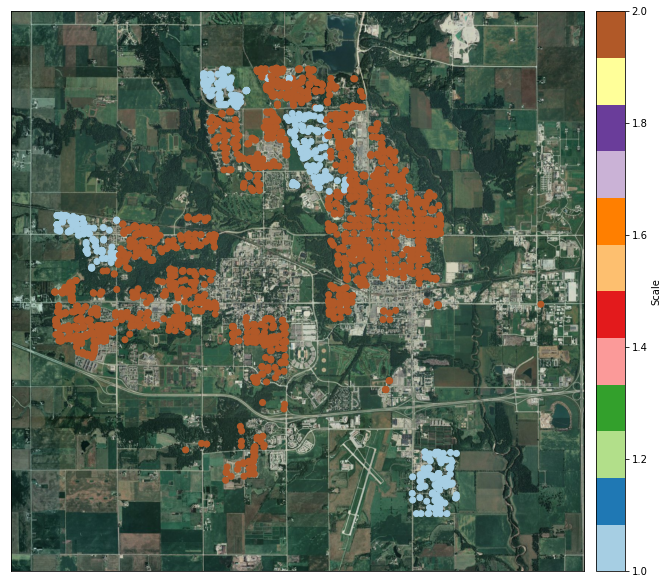

In [71]:
#Plotting neighborhood groups for UoI
plot_coordinates(df_nbhd_distgrp['latitude'].values, df_nbhd_distgrp['longitude'].values, 
                 df_nbhd_distgrp['plotting_uoi'].values)

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



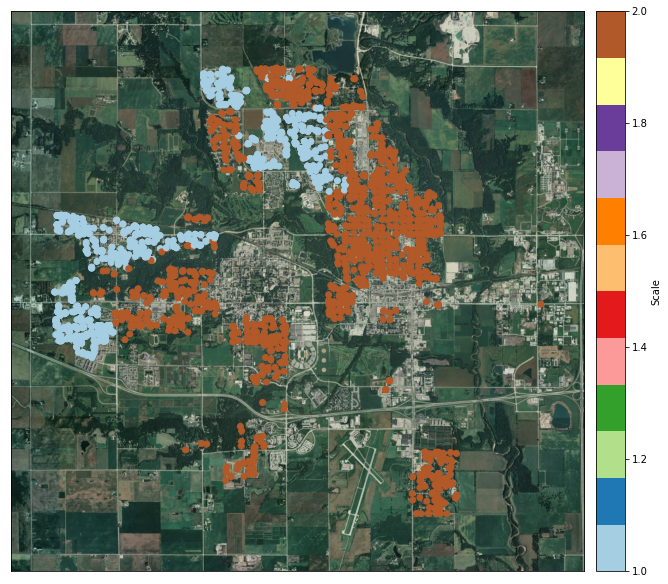

In [72]:
#Plotting neighborhood groups for DoT
plot_coordinates(df_nbhd_distgrp['latitude'].values, df_nbhd_distgrp['longitude'].values, 
                 df_nbhd_distgrp['plotting_dot'].values)

In [73]:
df_nbhd_distgrp.to_csv('df_nbhd_distgrp.csv', index = False)